# MS-SMC' validation

This notebook validates the MS-SMC' calculations from McKenzie and Eaton (XXXX) by comparing the analytical predictions to the results of stochastic coalescent simulations.

### Required software

In [1]:
from pathlib import Path
import ipcoal
import toytree
import toyplot
import pandas as pd
import numpy as np
from scipy import stats

### Create a directories to write results to

In [2]:
Path("../manuscript/figures/validation-plots-2024-final").mkdir(exist_ok=True)
Path("../manuscript/figures/smc-bias-plots-2024-final").mkdir(exist_ok=True)

### Generate results files
Run the Python script below to regenerate the results files analyzed in this notebook. Otherwise, these results files are already available from the Github repo, which we load below.

In [3]:
# %%bash
# python ../scripts/validate-2.py 

### Load results from batch script

In [4]:
# load 100K results files from batch script
RESULTS_DIR = Path("../batch-scripts/")
RESULTS_FILES = {}
SETUPS = [(1, 8), (2, 4), (8, 1), (8, 3)]
for (pops, samps) in SETUPS:
    RESULTS_FILES[(pops, samps)] = sorted(RESULTS_DIR.glob(f"validate-100K-npops{pops}-nsamps{samps}*.npy"))
RESULTS_FILES

{(1, 8): [PosixPath('../batch-scripts/validate-100K-npops1-nsamps8-full.npy'),
  PosixPath('../batch-scripts/validate-100K-npops1-nsamps8-smc.npy')],
 (2, 4): [PosixPath('../batch-scripts/validate-100K-npops2-nsamps4-full.npy'),
  PosixPath('../batch-scripts/validate-100K-npops2-nsamps4-smc.npy')],
 (8, 1): [PosixPath('../batch-scripts/validate-100K-npops8-nsamps1-full.npy'),
  PosixPath('../batch-scripts/validate-100K-npops8-nsamps1-smc.npy')],
 (8, 3): [PosixPath('../batch-scripts/validate-100K-npops8-nsamps3-full.npy'),
  PosixPath('../batch-scripts/validate-100K-npops8-nsamps3-smc.npy')]}

### Global parameters
These are global parameters used for analyses in the manuscript. The NLOCI variable is changed further below.

In [5]:
RECOMB = 2e-9
SPECIES_TREE_HEIGHT = 1e6
NEFF_MIN = 50_000
NEFF_MAX = 500_000
NEFF_VALS = 10
SEED = 123
NLOCI = 100_000
NREPS = 10

In [6]:
def get_sptree(ntips: int) -> toytree.ToyTree:
    """Return a balanced species tree with the specified number of tips and even branch lengths."""
    if ntips == 1:
        sptree = toytree.tree("(a);")
    else:
        sptree = toytree.rtree.baltree(ntips)
    sptree = sptree.mod.edges_scale_to_root_height(SPECIES_TREE_HEIGHT, include_stem=True)
    return sptree

In [7]:
toytree.mtree([get_sptree(8), get_sptree(2), get_sptree(1)]).draw(ts='p', scale_bar=True);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="675.0px" height="250.0px" viewBox="0 0 675.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0d79b96d94d948d89e2307508dd9928b"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 r0 r1 r2 r3 r4 r5 r6 r7 0 500000 1000000 0 1 2 r0 r1 0 500000 1000000 0 1 a 0 500000 1000000

## ----

### Load results

Error caused in analytical estimates is measured as $\frac{simulated - analytical}{analytical}$.

We want to know how different the simulated value is from our prediction, while weighting each measurement by the fact that some trees have very long predicted waiting distances while others have shorter predictions, and the error will generally be greater when the waiting distance is longer. We do not want to weight by the length of the true distances, since those are random variables and are sometimes very short or long by chance.

**If the error is positive it indicates that the simulated value is larger than the prediction**. 

In [8]:
def load_errors(full_path: str, smc_path: str):
    """Return the errors from the SMC' approximation.
    
    # results in arrays
    # 0 = smc_tree_probs (analytical) prediction
    # 1 = smc_topo_probs (analytical) prediction
    # 2 = smc_tree_dists (analytical) prediction
    # 3 = smc_topo_dists (analytical) prediction
    # 4 = sim_tree_dists (simulated) true
    # 5 = sim_topo_dists (simulated) true
    # 6 = sum_edge_lengths of genealogy 0
    # 7 = event type
    """
    res0 = np.load(full_path)  
    res1 = np.load(smc_path)  

    diff_full_tree = 100 * (res0[:, :, 4] - res0[:, :, 2]) / res0[:, :, 2]
    diff_full_topo = 100 * (res0[:, :, 5] - res0[:, :, 3]) / res0[:, :, 3]
    diff_smc_tree = 100 * (res1[:, :, 4] - res1[:, :, 2]) / res1[:, :, 2]
    diff_smc_topo = 100 * (res1[:, :, 5] - res1[:, :, 3]) / res1[:, :, 3]
    
    newdata = pd.DataFrame(
        data={
            # USING RES0 (FULL COAL W/ RECOMB)
            'prediction_minus_sim_full_tree_error_perc': diff_full_tree.mean(axis=0),
            'prediction_minus_sim_full_tree_error_perc_sem': stats.sem(diff_full_tree),

            'prediction_minus_sim_full_topo_error_perc': diff_full_topo.mean(axis=0),  
            'prediction_minus_sim_full_topo_error_perc_sem': stats.sem(diff_full_topo),
            
            # USING RES1 (SMC APPROX TO COAL W/ RECOMB)
            'prediction_minus_sim_smc_tree_error_perc': diff_smc_tree.mean(axis=0), 
            'prediction_minus_sim_smc_tree_error_perc_sem': stats.sem(diff_smc_tree),
            
            'prediction_minus_sim_smc_topo_error_perc': diff_smc_topo.mean(axis=0),
            'prediction_minus_sim_smc_topo_error_perc_sem': stats.sem(diff_smc_topo),
        },
        index=np.linspace(NEFF_MIN, NEFF_MAX, NEFF_VALS).astype(int),
    )
    return newdata

In [9]:
load_errors(*RESULTS_FILES[(8, 1)])

,prediction_minus_sim_full_tree_error_perc,prediction_minus_sim_full_tree_error_perc_sem,prediction_minus_sim_full_topo_error_perc,prediction_minus_sim_full_topo_error_perc_sem,prediction_minus_sim_smc_tree_error_perc,prediction_minus_sim_smc_tree_error_perc_sem,prediction_minus_sim_smc_topo_error_perc,prediction_minus_sim_smc_topo_error_perc_sem
50000,0.680477,0.319020,5.440135,0.374984,0.034298,0.316543,1.886290,0.345308
100000,0.523436,0.318986,5.034024,0.353620,-0.347819,0.315885,0.449676,0.323602
150000,-0.050420,0.316402,2.680761,0.336603,0.268511,0.317020,-0.122290,0.316497
200000,0.578068,0.319580,2.479373,0.331445,0.258213,0.317334,-0.198587,0.314770
250000,0.593296,0.317279,1.430685,0.328395,0.019205,0.314916,-0.192759,0.313856
300000,0.091522,0.316408,0.763048,0.323731,-0.265293,0.316733,-0.176126,0.315712
350000,0.256928,0.319931,0.827101,0.322139,-0.006010,0.315664,0.079482,0.316347
400000,-0.133446,0.316628,0.403359,0.321410,0.877026,0.318730,0.481166,0.317093
450000,-0.146088,0.315949,0.257999,0.320193,-0.505465,0.312428,-0.322736,0.315718
500000,0.374754,0.318563,0.515918,0.321792,-0.130236,0.316764,-0.232712,0.315278


In [10]:
def load_data(path):
    """Return large array results summarized into a dataframe.
    
    # 0 = smc_tree_probs
    # 1 = smc_topo_probs
    # 2 = smc_tree_dists
    # 3 = smc_topo_dists
    # 4 = sim_tree_dists
    # 5 = sim_topo_dists
    # 6 = sum_edge_lengths of genealogy 0
    # 7 = event type
    """
    results = np.load(path)  
    
    newdata = pd.DataFrame(
        data={
            'tree_smc_prob': results[:, :, 0].mean(axis=0),
            'topo_smc_prob': results[:, :, 1].mean(axis=0),
            'tree_smc_dist': results[:, :, 2].mean(axis=0),
            'topo_smc_dist': results[:, :, 3].mean(axis=0),       
            'tree_sim_prob': (results[:, :, 7] != 0).mean(0),
            'topo_sim_prob': (results[:, :, 7] == 2).mean(0),
            'tree_sim_dist': results[:, :, 4].mean(axis=0),
            'topo_sim_dist': results[:, :, 5].mean(axis=0),

            'tree_smc_prob_CI95':  tuple(zip(
                np.percentile(results[:, :, 0], 2.5, axis=0).round(5),
                np.percentile(results[:, :, 0], 97.5, axis=0).round(5),
            )),
            'topo_smc_prob_CI95':  tuple(zip(
                np.percentile(results[:, :, 1], 2.5, axis=0).round(5),
                np.percentile(results[:, :, 1], 97.5, axis=0).round(5),
            )),

            'tree_smc_dist_CI95':  tuple(zip(
                np.percentile(results[:, :, 2], 2.5, axis=0).round(5),
                np.percentile(results[:, :, 2], 97.5, axis=0).round(5),
            )),
            'topo_smc_dist_CI95':  tuple(zip(
                np.percentile(results[:, :, 3], 2.5, axis=0).round(5),
                np.percentile(results[:, :, 3], 97.5, axis=0).round(5),
            )),
            'tmrca': results[:, :, 6].mean(axis=0),
        },
        index=np.linspace(NEFF_MIN, NEFF_MAX, NEFF_VALS).astype(int),
    )
    newdata['nsamples'] = NLOCI * NREPS
    return newdata

In [11]:
data = load_data(RESULTS_FILES[(8, 1)][0])
data

,tree_smc_prob,topo_smc_prob,tree_smc_dist,topo_smc_dist,tree_sim_prob,topo_sim_prob,tree_sim_dist,topo_sim_dist,tree_smc_prob_CI95,topo_smc_prob_CI95,tree_smc_dist_CI95,topo_smc_dist_CI95,tmrca,nsamples
50000,0.341704,0.091294,258.460053,1584.402571,0.34138,0.09286,260.145254,1615.010238,"(0.31212, 0.3751)","(0.00885, 0.13489)","(210.8453, 305.77349)","(606.78098, 10580.41976)",5.700578e+06,1000000
100000,0.487695,0.160095,164.010828,601.251380,0.48818,0.16110,164.861843,627.126011,"(0.47097, 0.50937)","(0.05629, 0.28696)","(130.07023, 193.94443)","(255.80707, 1514.32462)",6.309423e+06,1000000
150000,0.568698,0.245196,128.023247,327.350809,0.57045,0.24694,127.976530,336.454843,"(0.55023, 0.58618)","(0.11873, 0.38446)","(98.34024, 154.51083)","(169.95007, 668.31597)",6.961955e+06,1000000
200000,0.619213,0.310371,108.132331,229.057940,0.61683,0.30970,108.820341,234.850204,"(0.59309, 0.63873)","(0.17606, 0.44783)","(80.80359, 133.87537)","(133.96066, 412.07153)",7.604400e+06,1000000
250000,0.653954,0.357817,95.111584,181.304421,0.65063,0.35901,95.700453,184.253418,"(0.61803, 0.67716)","(0.21609, 0.49073)","(69.33682, 120.54174)","(113.55165, 295.91434)",8.220855e+06,1000000
300000,0.679631,0.391489,85.579514,153.580160,0.67922,0.39410,85.644325,154.779779,"(0.63426, 0.70604)","(0.24185, 0.52485)","(61.05612, 110.65945)","(99.37746, 240.31537)",8.827048e+06,1000000
350000,0.699260,0.416855,78.289117,135.005833,0.70121,0.41939,78.392118,136.059642,"(0.64531, 0.72817)","(0.25918, 0.55073)","(54.92644, 103.07199)","(88.95871, 205.13407)",9.415087e+06,1000000
400000,0.714937,0.436067,72.463028,121.755478,0.71359,0.43649,72.382852,122.287426,"(0.65311, 0.7461)","(0.27006, 0.57233)","(49.9902, 96.84143)","(80.89609, 181.6279)",9.986317e+06,1000000
450000,0.727412,0.450443,67.556328,111.547104,0.72769,0.45455,67.471632,111.921896,"(0.65929, 0.7609)","(0.2751, 0.58821)","(45.77996, 91.87733)","(74.63264, 164.01905)",1.056662e+07,1000000
500000,0.738035,0.462283,63.441508,103.436792,0.73787,0.46470,63.670554,103.869356,"(0.66397, 0.7735)","(0.27969, 0.60336)","(42.47583, 87.30544)","(69.1998, 151.03069)",1.112754e+07,1000000


# Plot results

## Plot probabilities

In [12]:
def plot_probs(pops, samps, topo: bool=False, smc: bool=False):
    """Plot probabilities of tree or topology change.
    
    """
    # load results
    data = load_data(RESULTS_FILES[(pops, samps)][int(smc)])

    # labels for output
    smckey = "topo_smc_" if topo else "tree_smc_"
    simkey = "topo_sim_" if topo else "tree_sim_"
    
    # setup canvas and axes
    canvas = toyplot.Canvas(width=350, height=300)
    axb = canvas.cartesian(margin=65)
    axt = axb.share("y")
    axb.x.label.text = "N<sub>e</sub> (diploid) x 10^5"
    axt.x.label.text = "Sptree edge lengths (coal units)"
    axb.y.label.text = "P(topo-change | S,G)" if topo else "P(tree-change | S,G)"
    axb.y.domain.max = 1
    axb.y.domain.min = 0
    axb.x.domain.min = 0
    
    # style axes
    for ax in (axb.x, axt.x, axb.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 20
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3

    # set axis ticks
    sptree = get_sptree(pops)
    if sptree.ntips == 1:
        interval_len = np.inf
    else:
        interval_len = np.min([i.dist for i in sptree if not i.is_root()])
    axb.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(50_000, 500_000, 4),
        np.linspace(50_000, 500_000, 4) / 1e5,
    )
    axt.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(50_000, 500_000, 4),
        (interval_len / (2 * np.linspace(50_000, 500_000, 4))).round(1),
    )
        
    # plot data
    color = toytree.color.COLORS2[0]
    cmap = toyplot.color.brewer.palette("BlueRed", NEFF_VALS)
    axb.hlines([0, 0.5, 1.0], style={"stroke": "grey", "stroke-width": 2, "stroke-dasharray": "6,6", "stroke-opacity": 0.7})
    axb.fill(
       data.index,
       [i[0] for i in data[smckey + "prob_CI95"]],
       [i[1] for i in data[smckey + "prob_CI95"]],
       opacity=0.25,
       color="grey",
    )
    axb.plot(data.index, data[simkey + "prob"], stroke_width=2, color='black')
    style = dict(opacity=0.8, color='black', mstyle={"stroke": "none"})
    marks = [
        axb.scatterplot(data.index, data[smckey + "prob"], size=16,
                        color=[cmap[i] for i in range(NEFF_VALS)], 
                        mstyle={"stroke-width": 1.5, "fill-opacity": 0.5, "stroke": "black"}),
        axb.scatterplot(data.index, data[simkey + "prob"], size=6, marker='s', **style),
    ]
    return canvas

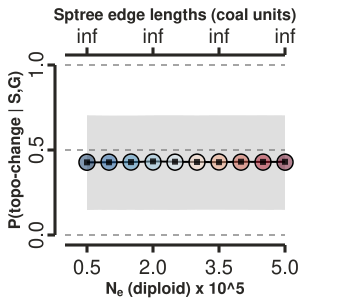

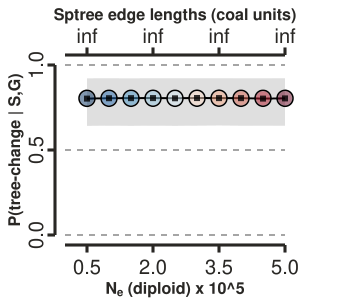

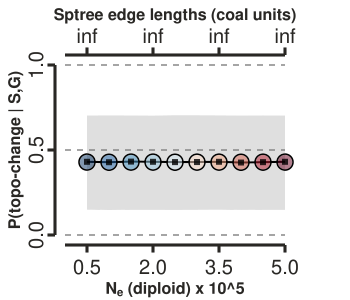

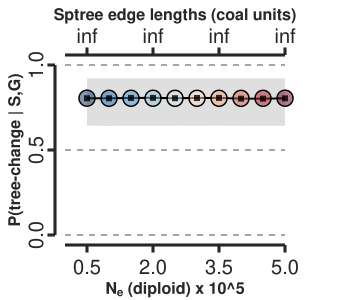

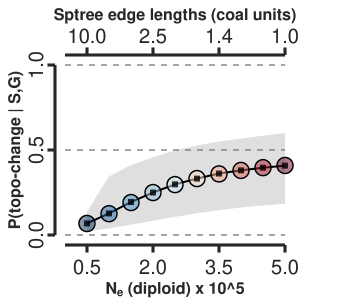

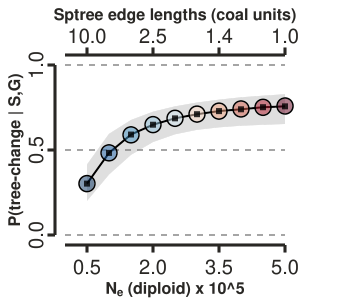

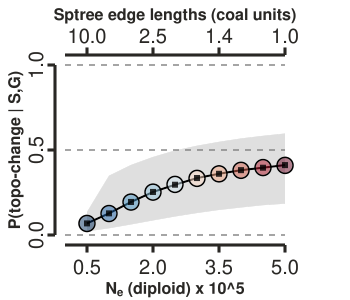

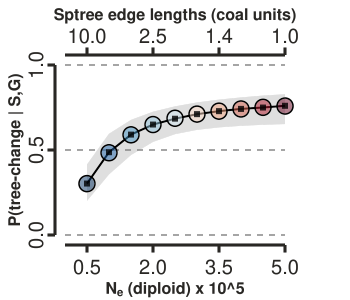

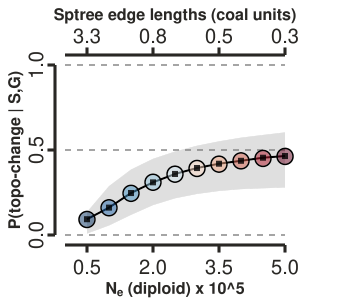

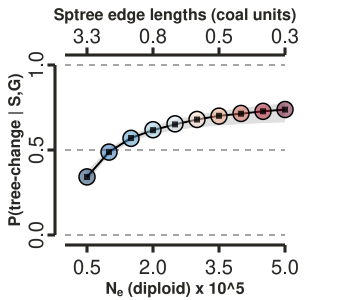

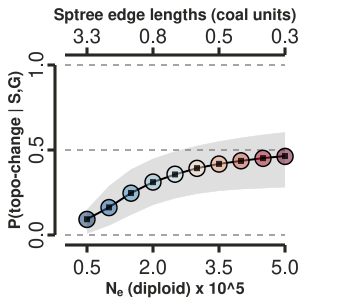

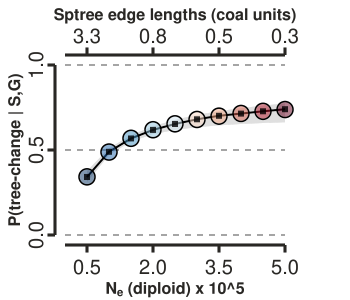

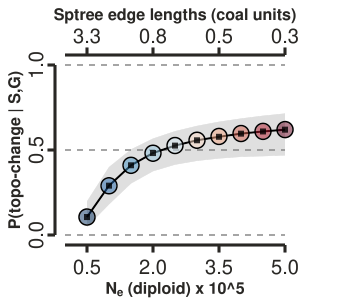

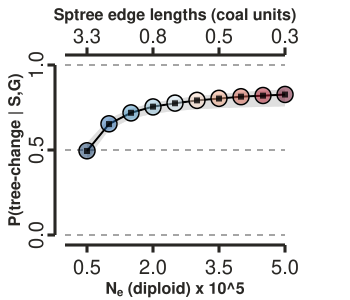

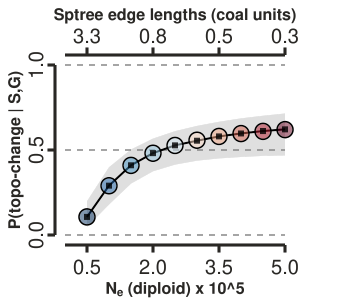

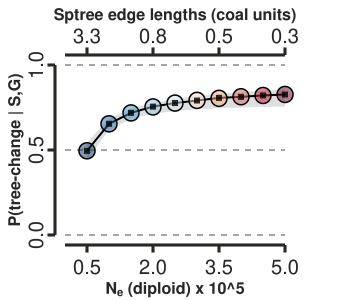

In [13]:
for (pops, samps) in SETUPS:
    for smc in [0, 1]:
        for topo in [True, False]:           
            canvas = plot_probs(pops, samps, topo=topo, smc=smc)
            ttt = 'topo' if topo else 'tree'
            toyplot.svg.render(canvas, 
                "../manuscript/figures/validation-plots-2024-final/"
                f"validation-colorprobs-{pops}pops-{samps}samps-{ttt}-smc{int(smc)}-final.svg"
            )
            display(canvas)

## Plot distances

In [14]:
def plot_distances(pops, samps, topo: bool=False, log: bool=True, smc: bool=False):
    """Plot waiting distances until tree or topology change.
    
    """
    # load results
    data = load_data(RESULTS_FILES[(pops, samps)][int(smc)])

    # labels for output
    smckey = "topo_smc_" if topo else "tree_smc_"
    simkey = "topo_sim_" if topo else "tree_sim_"
    
    # setup axes
    canvas = toyplot.Canvas(width=350, height=300)
    axb = canvas.cartesian(margin=65)
    axt = axb.share("y")#, yscale="log")
    axb.x.label.text = "N<sub>e</sub> (diploid) x 10^5"
    axt.x.label.text = "Sptree edge lengths (coal units)"
    axb.y.label.text = "Distance to topo-change" if topo else "Distance to tree-change"
    axb.x.domain.min = 0
        
    if log:
        axt.y.scale = "log"
        axb.y.domain.min = 50
        axb.y.domain.max = 1e4
    else:
        axb.y.domain.min = 1
        axb.y.domain.max = 10000
    
    # style axes
    for ax in (axb.x, axt.x, axb.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 20
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3

    sptree = get_sptree(pops)
    if pops == 1:
        interval_len = np.inf
    else:
        interval_len = np.min([i.dist for i in sptree if not i.is_root()])

    axb.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
        np.linspace(NEFF_MIN, NEFF_MAX, 4) / 1e5,
    )
    axt.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
        (interval_len / (2 * np.linspace(NEFF_MIN, NEFF_MAX, 4))).round(1),
    )
    axt.y.ticks.locator = toyplot.locator.Explicit([100, 1000, 10000])

    axb.hlines([100, 1000, 10000], style={"stroke": "grey", "stroke-width": 2, "stroke-dasharray": "6,6", "stroke-opacity": 0.7})

    # plot data
    color = toytree.color.COLORS2[0]
    cmap = toyplot.color.brewer.palette("BlueRed", NEFF_VALS)
    axb.fill(
       data.index,
       [i[0] for i in data[smckey + "dist_CI95"]],
       [i[1] for i in data[smckey + "dist_CI95"]],
       opacity=0.25, color="grey",
    )
    axb.plot(data.index, data[simkey + "dist"], stroke_width=3, color='black')#color)
    style = dict(opacity=0.8, color='black', mstyle={"stroke": "none"})
    marks = [
        axb.scatterplot(data.index, data[smckey + "dist"], 
                        size=16, marker="o", 
                        color=[cmap[i] for i in range(NEFF_VALS)], 
                        #opacity=0.5, 
                        mstyle={"stroke": "black", "stroke-width": 1.5, "fill-opacity": 0.5},
                       ),
        axb.scatterplot(data.index, data[simkey + "dist"], size=7, marker='s', **style),
    ]
    return canvas

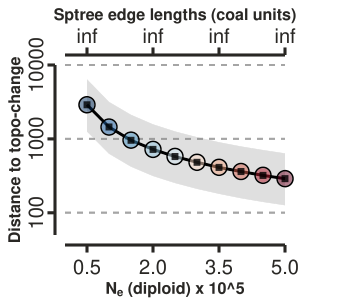

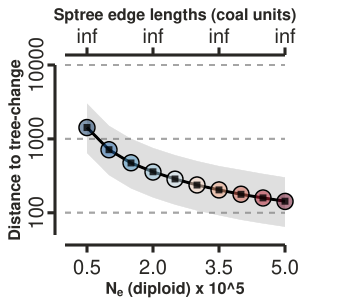

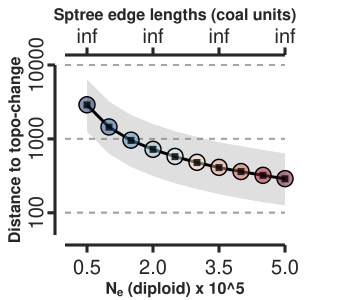

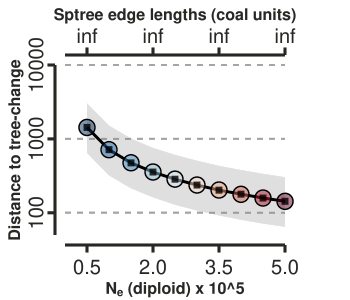

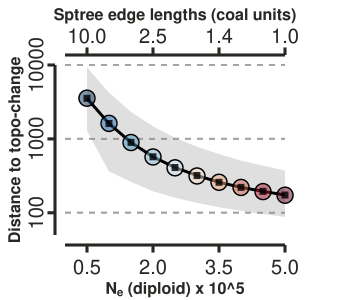

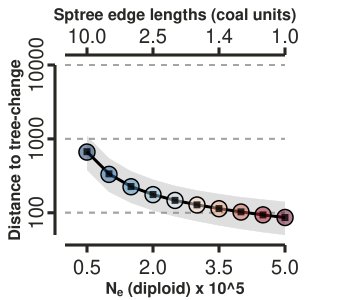

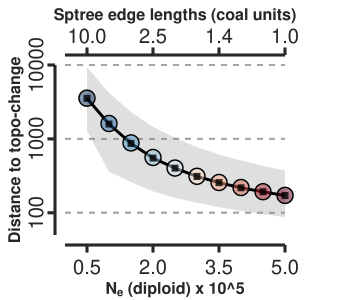

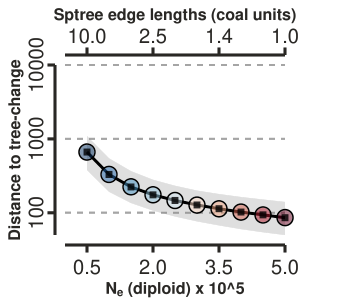

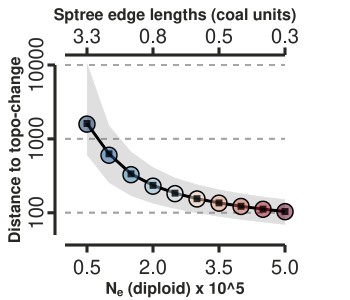

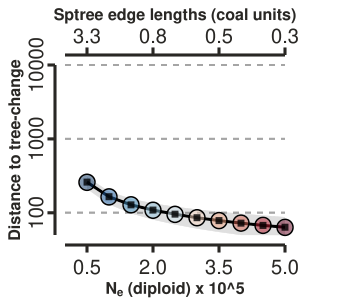

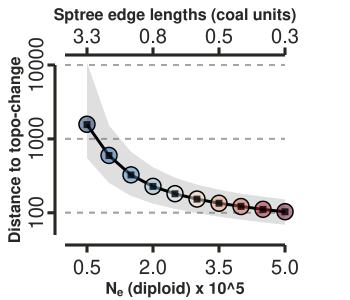

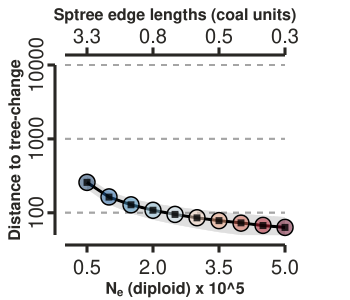

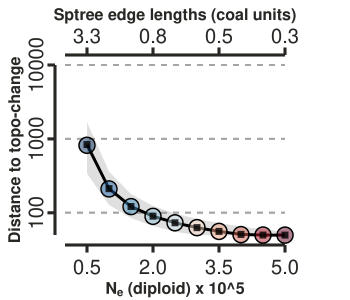

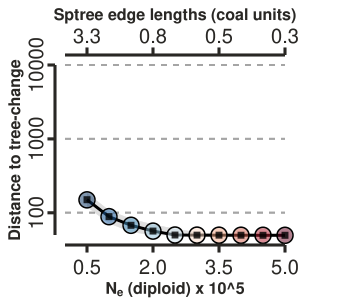

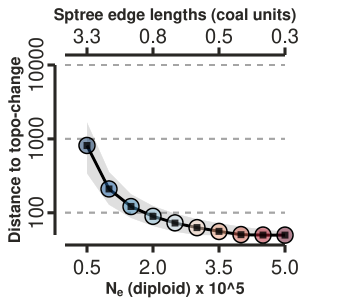

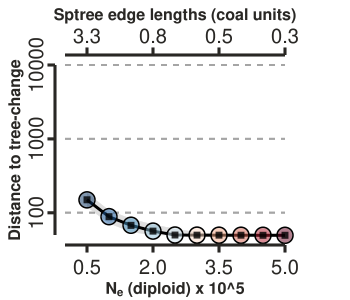

In [15]:
for (pops, samps) in SETUPS:
    for smc in [0, 1]:
        for topo in [True, False]:
            canvas = plot_distances(pops, samps, topo=topo, log=True, smc=smc)
            ttt = 'topo' if topo else 'tree'
            toyplot.svg.render(canvas, 
                "../manuscript/figures/validation-plots-2024-final/"
                f"validation-colordists-{pops}pops-{samps}samps-{ttt}-smc{int(smc)}-final.svg"
            )
            display(canvas)

## Plot error

In [16]:
def plot_error(pops, samps, topo: bool):
    """Plot the percent error for waiting distances between the analytical expectation
    and result of stochastic simulation, when data were simulated under either the
    full coalescent with recombination, or the SMC'.    
    """
    # load data
    fullpath, smcpath = RESULTS_FILES[(pops, samps)]
    fdata = load_errors(fullpath, smcpath)
    key = 'topo' if topo else 'tree'

    # setup axes
    canvas = toyplot.Canvas(width=350, height=300)
    axb = canvas.cartesian(margin=65)
    axt = axb.share("y")#, yscale="log")
    axb.x.label.text = "N<sub>e</sub> (diploid)"
    axt.x.label.text = "Sptree edge lengths (coal units)"
    axb.y.label.text = "Mean percent error"
    axb.x.domain.min = 0
    axb.y.domain.min = -10
    axb.y.domain.max = 10

    # style axes
    for ax in (axb.x, axt.x, axb.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 16
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3

    sptree = get_sptree(pops)
    avgdist = np.min([i.dist for i in sptree if not i.is_root()])
    axb.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
    )
    axt.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
        (avgdist / (2 * np.linspace(NEFF_MIN, NEFF_MAX, 4))).round(1),
    )

    axb.hlines([0], style={"stroke": "grey", "stroke-width": 2, "stroke-dasharray": "6,6", "stroke-opacity": 0.7})

    # plot data
    color = toytree.color.COLORS2[0]
    axb.fill(
       fdata.index,
       fdata[f"prediction_minus_sim_full_{key}_error_perc"] - 2*fdata[f"prediction_minus_sim_full_{key}_error_perc_sem"], 
       fdata[f"prediction_minus_sim_full_{key}_error_perc"] + 2*fdata[f"prediction_minus_sim_full_{key}_error_perc_sem"], 
       opacity=0.33,
    )
    axb.fill(
       data.index,
       fdata[f"prediction_minus_sim_smc_{key}_error_perc"] - 2*fdata[f"prediction_minus_sim_smc_{key}_error_perc_sem"], 
       fdata[f"prediction_minus_sim_smc_{key}_error_perc"] + 2*fdata[f"prediction_minus_sim_smc_{key}_error_perc_sem"], 
       opacity=0.33, color='black',
    )
    style = dict(opacity=0.8, color='black', mstyle={"stroke": "none"})
    marks = [
        axb.plot(fdata.index, fdata[f"prediction_minus_sim_full_{key}_error_perc"], 
                 size=6, marker="o", color=color, opacity=0.7),
        axb.plot(fdata.index, fdata[f"prediction_minus_sim_smc_{key}_error_perc"], 
                 size=6, marker='s', **style),
    ]
    canvas.text(200, 100, f"{key} {pops} black=smc green=full")
    return canvas

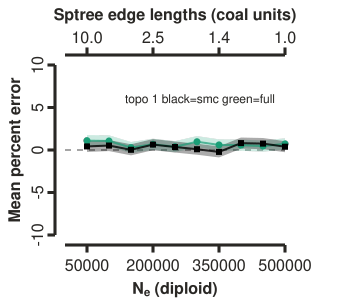

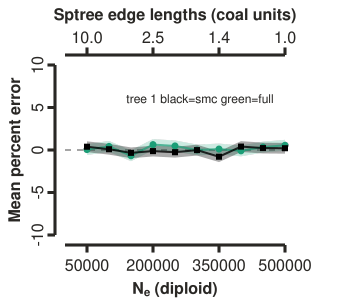

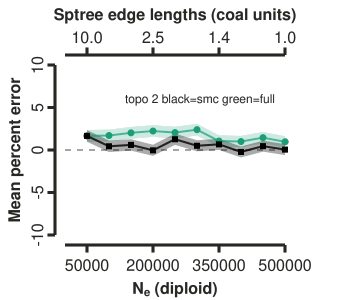

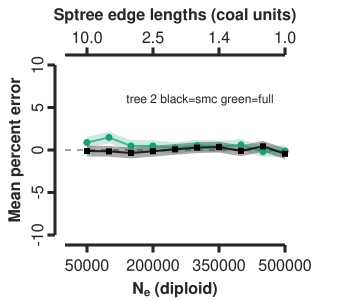

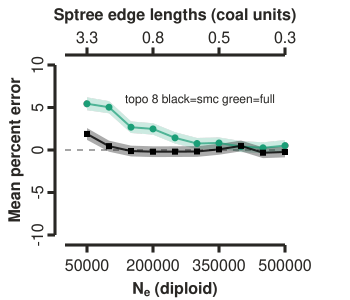

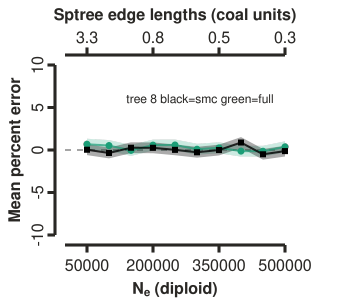

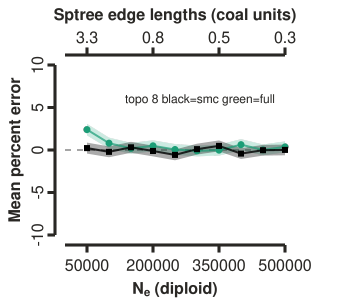

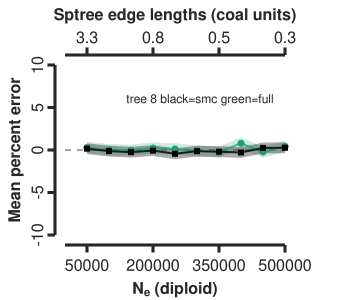

In [17]:
for (pops, samps) in SETUPS:
    for topo in [True, False]:
        canvas = plot_error(pops, samps, topo)
        ttt = 'topo' if topo else 'tree'
        toyplot.svg.render(
            canvas, 
            "../manuscript/figures/smc-bias-plots-2024-final/"
            f"error-p{pops}-s{samps}-{ttt}-final.svg"
        )
        display(canvas)

## Plot genealogy lengths

In [18]:
RESULTS_FILES

{(1, 8): [PosixPath('../batch-scripts/validate-100K-npops1-nsamps8-full.npy'),
  PosixPath('../batch-scripts/validate-100K-npops1-nsamps8-smc.npy')],
 (2, 4): [PosixPath('../batch-scripts/validate-100K-npops2-nsamps4-full.npy'),
  PosixPath('../batch-scripts/validate-100K-npops2-nsamps4-smc.npy')],
 (8, 1): [PosixPath('../batch-scripts/validate-100K-npops8-nsamps1-full.npy'),
  PosixPath('../batch-scripts/validate-100K-npops8-nsamps1-smc.npy')],
 (8, 3): [PosixPath('../batch-scripts/validate-100K-npops8-nsamps3-full.npy'),
  PosixPath('../batch-scripts/validate-100K-npops8-nsamps3-smc.npy')]}

In [19]:
cmap = toyplot.color.brewer.palette("BlueRed", 10)
cmap

In [20]:
def plot_distribution_of_genealogy_lens(pops: int, samps: int):
    
    data = np.load(RESULTS_FILES[(pops, samps)][0])

    canvas = toyplot.Canvas(width=350, height=300)
    axes = canvas.cartesian(
        xlabel="Genealogy sum length (x10<sup>6</sup>)",
        ylabel="Frequency",
        margin=65)
    
    cmap = toyplot.color.brewer.palette("BlueRed", 10)
    max_height = 24e6
    nes = np.linspace(NEFF_MIN, NEFF_MAX, NEFF_VALS).astype(int)
    nes = nes[[0, -1]]

    # ...
    axes.x.domain.min = 0
    axes.x.domain.max = max_height
    for ax in (axes.x, axes.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 20
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3
    axes.y.ticks.locator = toyplot.locator.Explicit(np.linspace(0.25, NEFF_VALS * 0.25, NEFF_VALS), [""] * NEFF_VALS)
    axes.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(0, max_height, 4),
        [int(i / 1e6) for i in np.linspace(0, max_height, 4)],
    )
    axes.vlines(
        np.linspace(0, max_height, 4), 
        style={"stroke": "grey", "stroke-width": 2, "stroke-dasharray": "6,6", "stroke-opacity": 0.7},
    )
    
    offset = NEFF_VALS * 0.25
    for nidx in range(NEFF_VALS):
        sumlens = data[:, nidx, 6]
        mag, pos = np.histogram(sumlens, bins=40)
        axes.fill(
            pos[:-1],
            np.repeat(offset, mag.size),
            offset + (mag/mag.max()), 
            style={'stroke': "none", "fill-opacity": 0.33, "fill": cmap[nidx]},
        )
        axes.plot(
            pos[:-1], 
            offset + (mag/mag.max()), 
            #color='black',
            color='black',#cmap[nidx],
            stroke_width=2, 
            style={"stroke-opacity": 0.7}
        )
        offset -= 0.25
        
    return canvas

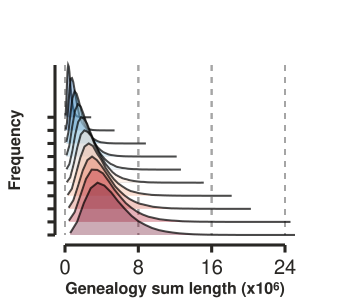

In [21]:
c = plot_distribution_of_genealogy_lens(1, 8)
toyplot.svg.render(c, "../manuscript/figures/validation-plots-2024-final/genealogy-sumlens-p1-s8.svg")
c

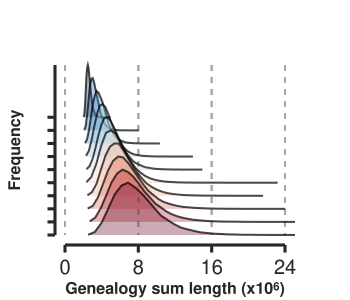

In [22]:
c = plot_distribution_of_genealogy_lens(2, 4)
toyplot.svg.render(c, "../manuscript/figures/validation-plots-2024-final/genealogy-sumlens-p2-s4.svg")
c

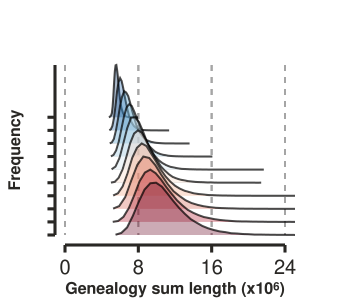

In [23]:
c = plot_distribution_of_genealogy_lens(8, 1)
toyplot.svg.render(c, "../manuscript/figures/validation-plots-2024-final/genealogy-sumlens-p8-s1.svg")
c

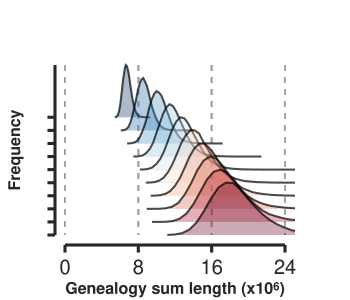

In [24]:
c = plot_distribution_of_genealogy_lens(8, 3)
toyplot.svg.render(c, "../manuscript/figures/validation-plots-2024-final/genealogy-sumlens-p8-s3.svg")
c